In [3]:
# imports and loading
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from pymodulon.io import *
from matplotlib_venn import venn3
from pymodulon.enrichment import *
import os
from statsmodels.stats.multitest import fdrcorrection

base_dir = '/home/chris/zuniga/iModulonMiner'
TRN_df = pd.read_csv(os.path.join(base_dir, 'data', 'external', 'TRN.csv'), index_col = 0)
#ica_data = load_json_model(os.path.join(base_dir, 'data', 'interim', 'zmo_raw.json.gz'))
data_dir = os.path.join('..','data','processed_data')
interim_dir = os.path.join('..','data','interim')
ica_data = load_json_model(os.path.join(data_dir,'ZM4_ica.json.gz'))

/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  table = pd.read_json(table)
/home/chris/miniforge3/envs/iM_miner/lib/python3.10/site-packages/pymodulon/util.py:31: FutureWarning: Passing literal json to 'read_json' 

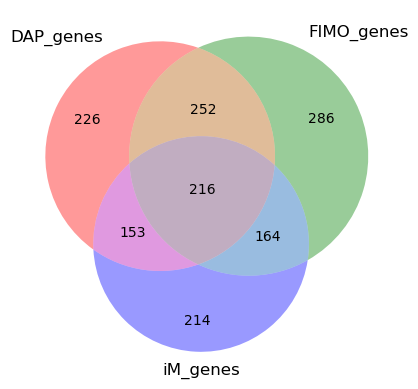

In [4]:
all_genes = set(ica_data.gene_table.index)
DAP_genes = set(TRN_df.gene_id)
df = ica_data.gene_table.fillna(0)
iM_genes = set(df[df['iMs'] != 0].index)
df = ica_data.gene_table
FIMO_genes = set(df[[type(val) != float and len(val) > 2 for val in ica_data.gene_table['FIMO_regulators']]].index)


venn3([DAP_genes, FIMO_genes, iM_genes], ('DAP_genes', 'FIMO_genes', 'iM_genes'))
plt.savefig(os.path.join(base_dir, 'figures', 'venn3_overlap.pdf'), transparent = True)
plt.show()

In [5]:
shared = list(DAP_genes.intersection(FIMO_genes).intersection(iM_genes))

In [6]:
a = ica_data.gene_table.loc[shared]['COG'].value_counts() / len(shared)
a1 = ica_data.gene_table.loc[list(iM_genes)]['COG'].value_counts() / len(list(iM_genes))

In [7]:
b = ica_data.gene_table['COG'].value_counts() / len(ica_data.gene_table.index)

In [8]:
(a1 - b).sort_values()

COG
Replication, recombination and repair                               -0.023651
Cell wall/membrane/envelope biogenesis                              -0.018781
Nucleotide transport and metabolism                                 -0.014384
Amino acid transport and metabolism                                 -0.012762
Cell cycle control, cell division, chromosome partitioning          -0.011355
Coenzyme transport and metabolism                                   -0.010691
Lipid transport and metabolism                                      -0.010501
Signal transduction mechanisms                                      -0.006390
Intracellular trafficking, secretion, and vesicular transport       -0.004956
Carbohydrate transport and metabolism                               -0.004330
Secondary metabolites biosynthesis, transport, and catabolism       -0.001073
Defense mechanisms                                                   0.000465
No COG category                                             

In [11]:
df = ica_data.gene_table
og_use = iM_genes-FIMO_genes-DAP_genes
results = []
for COG in a.index:
    target = df[df['COG'] == COG].index.to_list()
    gene_set = list(og_use)
    res = compute_enrichment(gene_set, target, df.index)
    results.append(res)
res_df = pd.DataFrame(results)
res_df['COG'] = a.index
_, qvalues = fdrcorrection(res_df['pvalue'])
res_df['qvalue'] = qvalues
res_df = res_df[['COG', 'pvalue', 'qvalue', 'precision', 'recall', 'f1score', 'TP', 'target_set_size', 'gene_set_size']]

In [12]:
res_df.sort_values(by = 'qvalue').head()

,COG,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,gene_set_size
11,"Translation, ribosomal structure and biogenesis",2.142331e-08,4.070429e-07,0.191589,0.264516,0.222222,41.0,155.0,214.0
16,Cell motility,6.482466e-04,6.158343e-03,0.060748,0.295455,0.100775,13.0,44.0,214.0
6,Energy production and conversion,1.336093e-03,8.461923e-03,0.102804,0.215686,0.139241,22.0,102.0,214.0
9,"Post-translational modification, protein turno...",3.038213e-02,1.443151e-01,0.060748,0.194030,0.092527,13.0,67.0,214.0
14,Coenzyme transport and metabolism,6.588716e-02,2.503712e-01,0.065421,0.170732,0.094595,14.0,82.0,214.0


In [13]:
len(og_use)

214

In [25]:
qvalues

array([9.99946230e-01, 1.32367562e-02, 3.32677392e-04, 9.99946230e-01,
       9.99946230e-01, 6.80769212e-03, 9.99946230e-01, 9.99946230e-01,
       9.99946230e-01, 9.99946230e-01, 9.99946230e-01, 5.54788718e-01,
       3.32489515e-01, 3.32489515e-01, 9.99946230e-01, 9.99946230e-01,
       9.99946230e-01, 9.99946230e-01])